# (Tb - cpT) histograms
Get the histograms & save those dicts/plots (save the climo only, not individual years); then you can put the counts in the binned plots! 

### **saves the (Tb - cpT) count/histogram dictionaries**

In [1]:
import pickle
import sys
sys.path.append("/home/b/b380887/cold-point-overshoot/python_scripts/")

import xarray as xr
import numpy as np
import bin_obs_overshoot as boo


In [2]:
season = "DJF"

if season == "DJF":
    region_list = ["SPC", "AMZ", "ECP", "IOS"]
    year_list = [2007, 2008, 2009, 2010]
    
elif season == "JJA":
    region_list = ["AFR", "WPC", "ECP", "IOE"]
    year_list = [2007, 2008, 2009, 2010] # TODO: add 2006 when done
    
years_sorted = list(sorted(year_list))
years_str = str(years_sorted[0]) + "-" + str(years_sorted[-1])
print(years_str)


2007-2010


In [3]:
file_path = "/work/bb1153/b380887/big_obs_climo/{s}/".format(s=season)
save_dir = "/home/b/b380887/cold-point-overshoot/plots/obs_paper/Tb-cpT_hists/"
pickle_save_dir = "/home/b/b380887/cold-point-overshoot/pickle_files/obs_tb-cpt_hists/"


In [4]:
%%time

diffs_dar_dict = {}
ds_dar_dict = {}

for region in region_list:
    diffs_dar_list = [[]]*len(year_list)
    
    if region == "SPC":
        ds_dar_list = [[]]*len(year_list)
        for i, year in enumerate(year_list):
            ds_dar_1 = xr.open_dataset(file_path + "DARDAR-v3_iwc_{s}{y}_{r}1.nc".format(s=season, y=year, r=region))
            ds_dar_2 = xr.open_dataset(file_path + "DARDAR-v3_iwc_{s}{y}_{r}2.nc".format(s=season, y=year, r=region))
            _, tb_1, cpT_ri_1 = boo.get_data(season, year, "SPC1", file_path=file_path, bin_by_diffs=True)
            _, tb_2, cpT_ri_2 = boo.get_data(season, year, "SPC2", file_path=file_path, bin_by_diffs=True)
            
            iwc2d_1 = ds_dar_1["iwc"].isel(height=0)
            iwc2d_2 = ds_dar_2["iwc"].isel(height=0)
            
            tb_dar_1 = tb_1.sel(time=ds_dar_1["iwc"].time, lat=iwc2d_1.lat, lon=iwc2d_1.lon, method="nearest")
            cpT_ri_dar_1 = cpT_ri_1.sel(time=ds_dar_1["iwc"].time, lat=iwc2d_1.lat, lon=iwc2d_1.lon, method="nearest")
            tb_dar_2 = tb_2.sel(time=ds_dar_2["iwc"].time, lat=iwc2d_2.lat, lon=iwc2d_2.lon, method="nearest")
            cpT_ri_dar_2 = cpT_ri_2.sel(time=ds_dar_2["iwc"].time, lat=iwc2d_2.lat, lon=iwc2d_2.lon, method="nearest")

            diffs_dar_1 = xr.DataArray(
                (tb_dar_1.values - cpT_ri_dar_1.values),
                dims=["time"],
                coords={"time": iwc2d_1.time}
            )
            diffs_dar_2 = xr.DataArray(
                (tb_dar_2.values - cpT_ri_dar_2.values),
                dims=["time"],
                coords={"time": iwc2d_2.time}
            )

            ds_dar_list[i] = xr.concat([ds_dar_1, ds_dar_2], dim="time")
            diffs_dar_list[i] = xr.concat([diffs_dar_1, diffs_dar_2], dim="time")
            print(region, year, "done")
    else:
        ds_dar_list = [
            xr.open_dataset(file_path + "DARDAR-v3_iwc_{s}{y}_{r}.nc".format(s=season, y=year, r=region))
            for year in year_list
        ]
        output_list = [
            boo.get_data(season, year, region, file_path=file_path, bin_by_diffs=True)
            for year in year_list
        ]
        tb_list = [output_list[i][1] for i in range(len(output_list))]
        cpT_ri_list = [output_list[i][2] for i in range(len(output_list))]

        for i, ds_dar in enumerate(ds_dar_list):
            iwc = ds_dar["iwc"]
            iwc2d = iwc.isel(height=0)
            tb_dar = tb_list[i].sel(time=iwc.time, lat=iwc2d.lat, lon=iwc2d.lon, method="nearest")
            cpT_ri_dar = cpT_ri_list[i].sel(time=iwc.time, lat=iwc2d.lat, lon=iwc2d.lon, method="nearest")
            diffs_dar_vals = tb_dar.values - cpT_ri_dar.values
            diffs_dar = xr.DataArray(diffs_dar_vals, dims=["time"], coords={"time": iwc.time})
            diffs_dar_list[i] = diffs_dar

    diffs_dar_dict[region] = xr.concat(diffs_dar_list, dim="time")
    ds_dar_dict[region] = ds_dar_list
    print(region, "done")


SPC 2007 done
SPC 2008 done
SPC 2009 done
SPC 2010 done
SPC done
AMZ done
ECP done
IOS done
CPU times: user 8.04 s, sys: 27.1 s, total: 35.2 s
Wall time: 7min 52s


## Make plots + (Tb-cpT) hist dictionaries

In [5]:
def save_diff_hist_dict(hist_out, season, years_str, region, pickle_dir):
    """ 
    Save the counts, bins, bin edges, and total # of points
    for one histogram as a pickled dictionary.
    """
    diff_counts, diff_bins, diff_bin_edges, n_pts = hist_out

    hist_dict = {
        "counts": diff_counts,
        "freqs": diff_counts/n_pts,
        "bins": diff_bins,
        "edges": diff_bin_edges,
        "n_pts": n_pts
    }

    out_file = pickle_dir + "Tb-cpT_histogram_dict_{s}{y}_{r}.pickle".format(s=season, y=years_str, r=region)
    with open(out_file, "wb") as handle:
        pickle.dump(hist_dict, handle)
        
    print("dictionary saved to", out_file)
    

In [6]:
save = True
ylim = (0, 0.14)


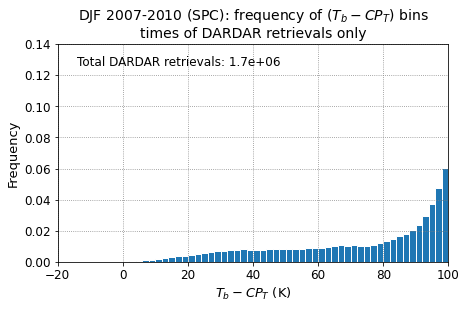

dictionary saved to /home/b/b380887/cold-point-overshoot/pickle_files/obs_tb-cpt_hists/Tb-cpT_histogram_dict_DJF2007-2010_SPC.pickle


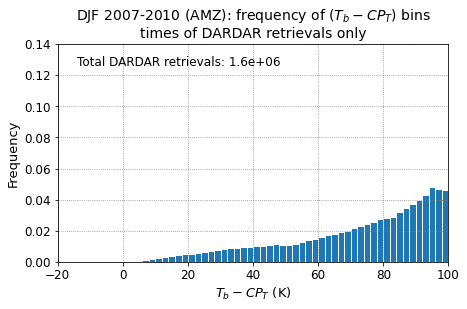

dictionary saved to /home/b/b380887/cold-point-overshoot/pickle_files/obs_tb-cpt_hists/Tb-cpT_histogram_dict_DJF2007-2010_AMZ.pickle


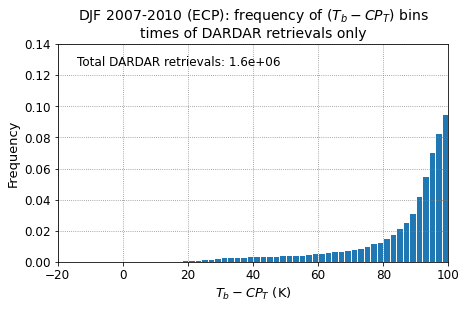

dictionary saved to /home/b/b380887/cold-point-overshoot/pickle_files/obs_tb-cpt_hists/Tb-cpT_histogram_dict_DJF2007-2010_ECP.pickle


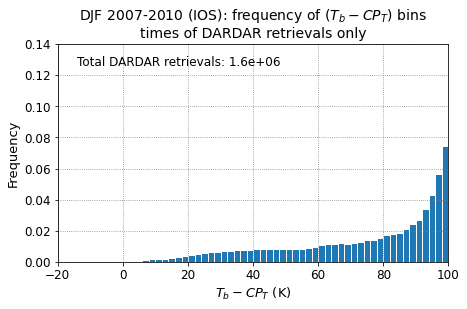

dictionary saved to /home/b/b380887/cold-point-overshoot/pickle_files/obs_tb-cpt_hists/Tb-cpT_histogram_dict_DJF2007-2010_IOS.pickle


In [8]:
# DJF
for region in region_list:
    diffs_dar_cat = diffs_dar_dict[region]
    ds_dar_list = ds_dar_dict[region]
    
    hist_out = boo.plot_diffs_hist(diffs_dar_cat, season, region, years_str, 
                                 dar_times_only=True, annotate_total=True,
                                 dar_list_ds=ds_dar_list, ylim=ylim,
                                 return_hist=True, save=save, save_dir=save_dir
                                )
    save_diff_hist_dict(hist_out, season, years_str, region, pickle_dir=pickle_save_dir)


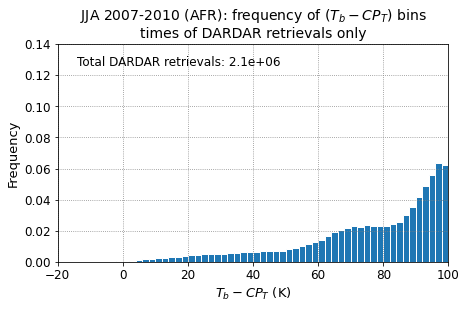

dictionary saved to /home/b/b380887/cold-point-overshoot/pickle_files/obs_tb-cpt_hists/Tb-cpT_histogram_dict_JJA2007-2010_AFR.pickle


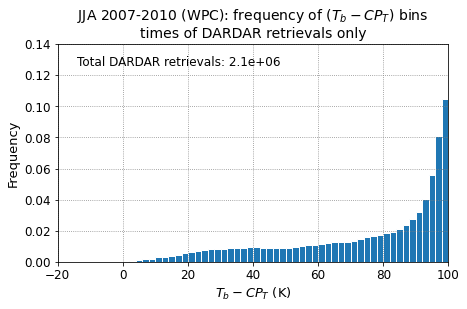

dictionary saved to /home/b/b380887/cold-point-overshoot/pickle_files/obs_tb-cpt_hists/Tb-cpT_histogram_dict_JJA2007-2010_WPC.pickle


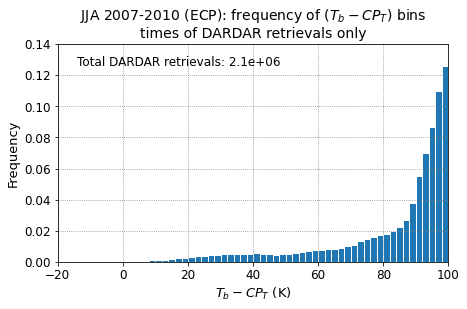

dictionary saved to /home/b/b380887/cold-point-overshoot/pickle_files/obs_tb-cpt_hists/Tb-cpT_histogram_dict_JJA2007-2010_ECP.pickle


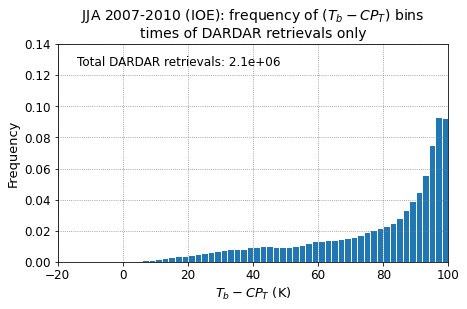

dictionary saved to /home/b/b380887/cold-point-overshoot/pickle_files/obs_tb-cpt_hists/Tb-cpT_histogram_dict_JJA2007-2010_IOE.pickle


In [14]:
# JJA
for region in region_list:
    diffs_dar_cat = diffs_dar_dict[region]
    ds_dar_list = ds_dar_dict[region]
    
    hist_out = boo.plot_diffs_hist(diffs_dar_cat, season, region, years_str, 
                                 dar_times_only=True, annotate_total=True,
                                 dar_list_ds=ds_dar_list, ylim=ylim,
                                 return_hist=True, save=save, save_dir=save_dir
                                )
    save_diff_hist_dict(hist_out, season, years_str, region, pickle_dir=pickle_save_dir)
